# Gravitational Lens Example 

We are given that a simplified model of the SIS lens equation is given as $$\vec{\beta} = \vec{\theta} - \theta_{E}\hat{\theta}$$
Where $\theta_{E}$ is the Einstein radius of the lens, $\vec{\beta}$ is the angular direction in the source plane, and $\vec{\theta}$ is the direction in the image plane. We can generate images as if they were obscured by an SIS lens. 

## Import Packages

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
from PIL import Image
%matplotlib inline

## Display Base Image
The image that I'll be demonstrating is the M51 spiral galaxy.

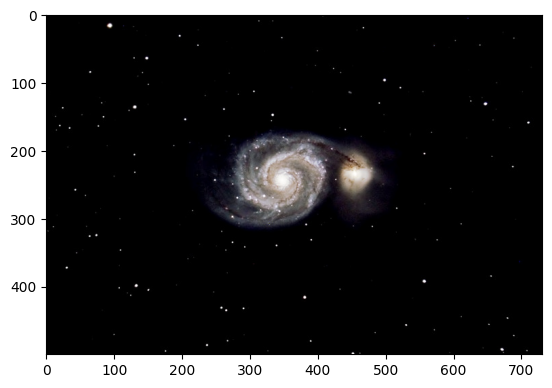

In [2]:
m51_raw = Image.open('images/m51small.jpeg') 
m51 = np.array(m51_raw) 

# Now display the image 
plt.imshow(m51)

## Coordinate transformation
In order to go from the regular image to the lensed image, we need to generate a funciton that calculates the mapping between the source to the image.

In [10]:
def image_to_source_coordinates(pixel_x, pixel_y, e_radius, lens_center): 
    """
        Function that returns the coordinates that should be sampled from the source given a pixel location in the (transformed) 
        image. 

        pixel_x and pixel_y are the x and y coordinates the image
        NOTE: this is the COLUMN and ROW coordinates, effectively. 
        
        e_radius is defined as the einstein radius of the gravitational lens, in pixels
 
        lens_center is a 2 element tuple describing the center of the lens (x, y)
    """

    # Establish a center of the image 
    center_x = lens_center[0] 
    center_y = lens_center[1] 

    # Calculate polar coordinates relative to the lens center
    relative_x = pixel_x - center_x 
    relative_y = pixel_y - center_y 

    pixel_angle = np.arctan2(relative_y, relative_x) 
    pixel_radius = np.linalg.norm(np.array([relative_x, relative_y]))

    # Then convert back to pixel coordinates (which may not be at an exact pixel location) 
    new_pixel_x = (pixel_radius - e_radius) * np.cos(pixel_angle) + center_x 
    new_pixel_y = (pixel_radius - e_radius) * np.sin(pixel_angle) + center_y 

    return new_pixel_x, new_pixel_y
    
    

## Image Sampling and Interpolation 
Now we need to devise a way to sample an image at x and y coordinates. We should add a bilinear interpolation method to this, as we might request a pixel location that is not an integer. 

In [34]:
def sample_image(pixel_x, pixel_y, image): 
    """
    Function that returns the intensity value(s) of an image at the specified coordinates, 
    and does interpolation as necessary.

    Args:
    - pixel_x (float): The x-coordinate (column) of the pixel.
    - pixel_y (float): The y-coordinate (row) of the pixel.
    - image (numpy array): The image data as a numpy array (NxPxK).

    Returns:
    - value (float or numpy array): The intensity value at the specified coordinates.
    """

    # Get the dimensions of the image
    if len(image.shape) == 2:  # Grayscale image
        height, width = image.shape
        channels = 1
    elif len(image.shape) == 3:  # Color image
        height, width, channels = image.shape
    else:
        raise ValueError("Invalid image shape")

    # Getting the integer and fractional parts of the coordinates
    x1, y1 = int(np.floor(pixel_x)), int(np.floor(pixel_y))
    x2, y2 = min(x1 + 1, width - 1), min(y1 + 1, height - 1)

    # Check if the coordinates are out of the image bounds
    if x1 >= width or y1 >= height or x1 < 0 or y1 < 0:
        return 0 if channels == 1 else np.zeros(channels, dtype=image.dtype)

    # Fractional parts
    a, b = pixel_x - x1, pixel_y - y1

    # Check if coordinates are already on a pixel
    on_pixel = a == 0 and b == 0

    # Adjust for edge cases
    if x1 == width - 1 or x2 >= width:
        x2, a = x1, 0
    if y1 == height - 1 or y2 >= height:
        y2, b = y1, 0

    # Bilinear interpolation
    if channels == 1:  # Grayscale
        value = image[y1, x1] if on_pixel else (
            image[y1, x1] * (1 - a) * (1 - b) + 
            image[y1, x2] * a * (1 - b) + 
            image[y2, x1] * (1 - a) * b + 
            image[y2, x2] * a * b)
    else:  # Color image
        value = np.zeros(channels, dtype=image.dtype)
        for c in range(channels):
            value[c] = image[y1, x1, c] if on_pixel else (
                image[y1, x1, c] * (1 - a) * (1 - b) + 
                image[y1, x2, c] * a * (1 - b) + 
                image[y2, x1, c] * (1 - a) * b + 
                image[y2, x2, c] * a * b)

    return value

## Lens Algorithm 
Now we just need to perform our algorithm, where we can compile our 2 functions from before, and return the transformed image. 

In [29]:
def compute_lensed_image(image, e_radius, lens_center): 

    # Create a blank image which we'll eventually return 
    new_image = np.zeros_like(image) 

    # Then we iterate over the image 
    for pixel_y in range(image.shape[0]): 
        for pixel_x in range(image.shape[1]): 

            # Then we compute the transformation. First get new coordinates 
            new_pixel_x, new_pixel_y = image_to_source_coordinates(pixel_x, pixel_y, e_radius, lens_center)

            # Then sample the old image 
            if len(image.shape) == 2: 
                new_image[pixel_y, pixel_x] = sample_image(new_pixel_x, new_pixel_y, image) 
            else: 
                new_image[pixel_y, pixel_x, :] = sample_image(new_pixel_x, new_pixel_y, image) 

    # Then return the new image 
    return new_image 

## Testing the implementation 
Now we can test the implementation on our original image, after we define some parameters

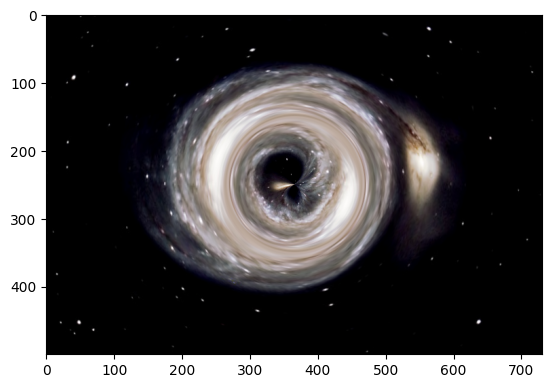

In [30]:
e_radius = 100 # pixels
lens_center = (m51.shape[1]/2, m51.shape[0]/2) # Approximate center of the image 

# Now get new image 
lensed_image = compute_lensed_image(m51, e_radius, lens_center)

# And display the image 
plt.imshow(lensed_image)

This looks good! Let's see if we can generate an animation of the SIS lens walking though the image plane

In [31]:
import imageio
from IPython.display import Image, display

# Let's generate a set of images, based on a moving gravlens 
e_radius = 100 

# Vary the lens center to go across the image
num_images = 10 
centers_x = np.linspace(start=0, stop=m51.shape[1], num=num_images)
centers_y = m51.shape[0]/2 * np.ones_like(centers_x)

# Set some GIF parameters
filename = 'images/m51lens.gif'
duration = 1 #seconds


In [32]:
# Generate the GIF
with imageio.get_writer(filename, mode='I', duration=duration) as writer: 
    for i in range(len(centers_x)): 
        lens_center = (centers_x[i], centers_y[i])
        new_lensed_image = compute_lensed_image(m51, e_radius, lens_center)
        writer.append_data(new_lensed_image) 

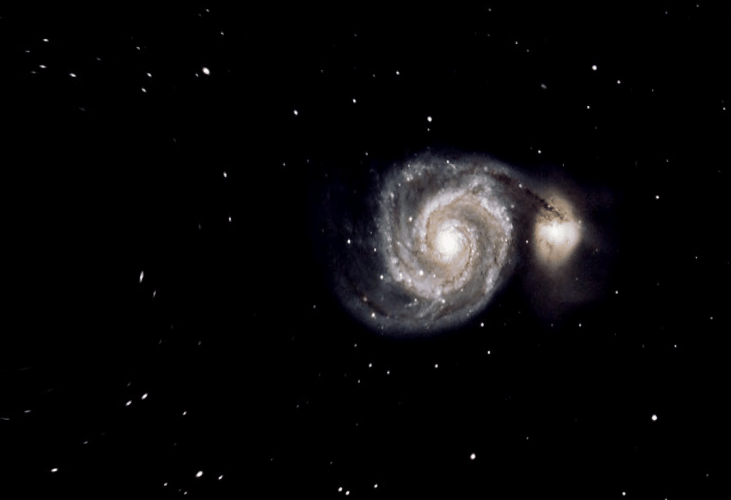

In [33]:
# Display the GIF 
with open(filename, 'rb') as file: 
    display(Image(data=file.read(), format='png'))